<a href="https://colab.research.google.com/github/Juanda16/ai-digit-recognizer/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T193754Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D20e77fe92c003cabbdd7e4e82d429b5b76a0760dc5587bec8bce2483450c91c95b194ef3ac5c49f5a88099422c1e71da170edd64847c64854e0957db66ca3f70966cd30442085df9a241fffdc134e867ea56b08f8f7be36e979cfb3211b6eac164d5787da0eee17e258e46150c2e01a9ebad53ae44e316303eaf47d66466d1b30851a81a6bf3da70e518bf44d7fffb0f607053277c6fbd94d25f976b1789b392c3d4fef62d076e96488964f88a6583c92c572e4b7dbf9900c70d1743947ce67cacaf42bc29119da3726d95c181c1067b8c40255b443d906183d8b7415b3cd1d472cd7e2c6d77ba79516775c6a10b363e93551aea09c82450e30775163c180480'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

In [3]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train.head()

print("train shape: ",train.shape)
print("test shape: ",test.shape)

train shape:  (42000, 785)
test shape:  (28000, 784)


In [4]:
print(train['label'].unique())
print(train['label'].nunique())

[1 0 4 7 3 5 8 9 2 6]
10


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y_train = train.iloc[:,:1]
x_train = train.iloc[:,1:]
x_test = test
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (42000, 784)
y_train shape:  (42000, 1)
x_test shape:  (28000, 784)


In [8]:
#Normalize

x_train = x_train/255.
x_test  = x_test/255.

#Reshape images

x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

#One-hot encoding

num_classes=10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (42000, 28, 28, 1)
y_train shape:  (42000, 10)
x_test shape:  (28000, 28, 28, 1)


In [9]:
print(x_train.ndim)

4


In [10]:
#Printing original labels of top 5 rows
print(train['label'].head())

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


In [11]:
#One hot encoding of the same labels
print(y_train[0:5,:])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


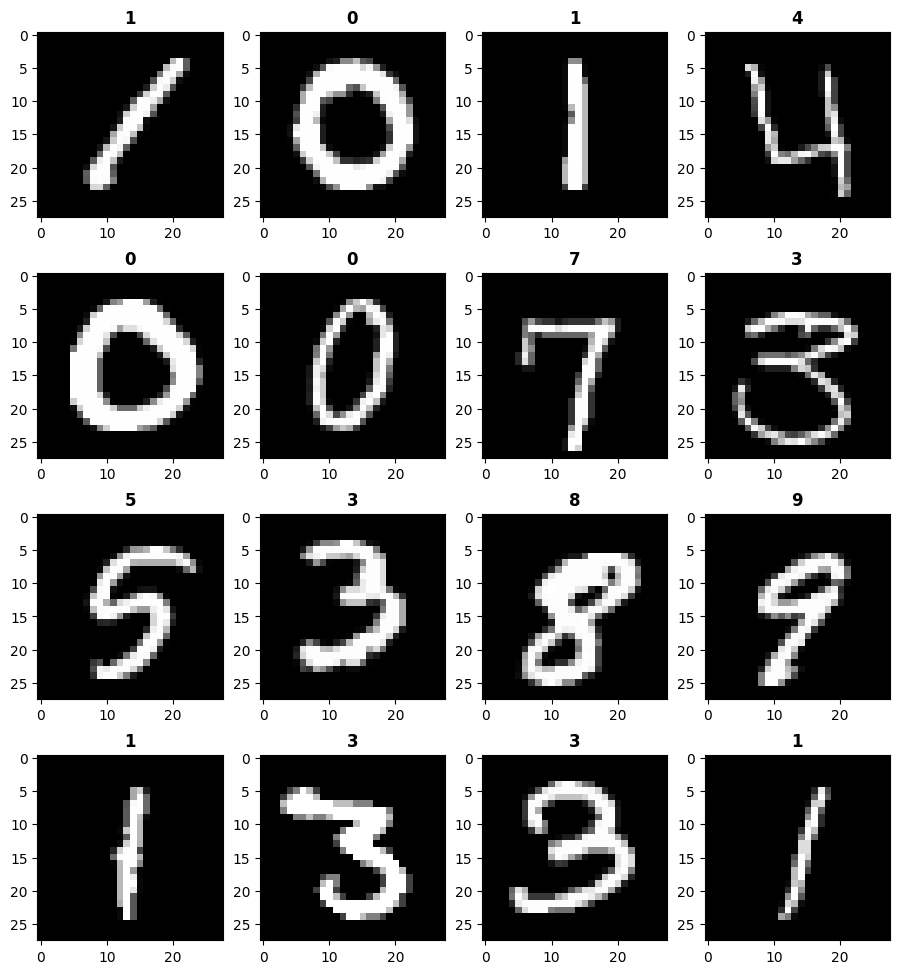

In [12]:
fig = plt.figure(figsize = (11, 12))

for i in range(16):
    plt.subplot(4,4,1 + i)
    plt.title(np.argmax(y_train[i]),fontname="Aptos",fontweight="bold")
    plt.imshow(x_train[i,:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

In [13]:
#Defining the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,(3,3),activation = 'relu', input_shape=(28,28,1)),
  tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',padding = 'Same'),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',padding = 'Same'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',padding = 'Same'),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',padding = 'Same'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(0.50),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.50),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                   

In [17]:
#Defining the callback function to stop our training once the acceptable accuracy is reached
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy') > 0.9):
                print("\nReached 99.9% accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [18]:
#Compiling and model training with batch size = 256, epochs = 100, and optimizer = adam
Optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0005,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            name='Adam'
)
model.compile(optimizer=Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size = 256, epochs = 100, callbacks=[callbacks])

Epoch 1/100
165/165 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960
Reached 99.9% accuracy so cancelling training!
165/165 [==============================] - 122s 723ms/step - loss: 0.0136 - accuracy: 0.9960


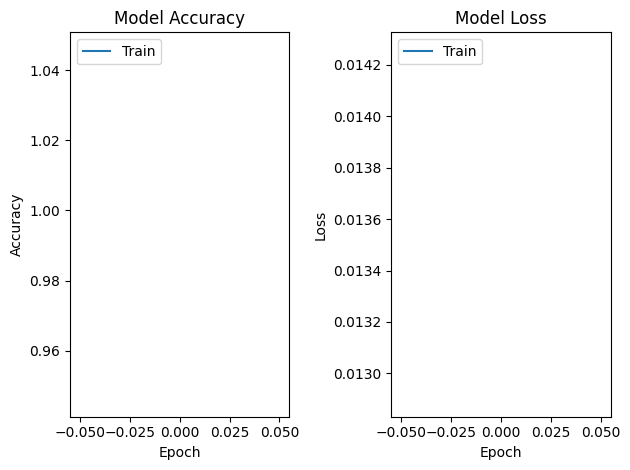

In [19]:
# Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Show the graphic
plt.tight_layout()
plt.show()


In [20]:
results = model.predict(x_test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 26s 29ms/step


In [21]:
print(results)

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64


In [22]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)

In [ ]:
submission = pd.read_csv('/kaggle/working/submission.csv')
print(submission.head())
print(submission.info())